In [1]:
%matplotlib inline

import os
import glob

import numpy as np
import pandas as pd

from astropy.io import fits
from astropy.table import Table

from desispec.interpolation import resample_flux

from collections import Counter

import matplotlib as mpl
from matplotlib import pyplot as plt

mpl.rc('font', family='serif', size=16)

In [2]:
# Load in the data
basedir = '/Users/ryanrubenzahl/Documents/DESI/my_outlier_detection/'
specdir = 'galaxy_sim_catalog/spectra/'
expid = 4

scaled_sne = ['distscale_atpeak',
              'bright_atpeak', 'dim_atpeak/', 'faint_atpeak']

sn_dir = scaled_sne[2]              
gal_globpath = basedir + specdir + 'galaxies/*expid%03d*.fits' % expid
sn_globpath  = basedir + specdir + sn_dir + '/*expid%03d*.fits' % expid

# Galaxies without supernovae
gal_files = glob.glob(gal_globpath)
# Galaxies with supernovae
sn_host_files = glob.glob(sn_globpath)
# All the files
all_files = np.append(gal_files, sn_host_files)

print len(gal_files), "total galaxies"
print len(sn_host_files), "total sn hosts"

21000 total galaxies
18900 total sn hosts


## Read in the data to an astropy table

In [3]:
data = []

for n, f in enumerate(all_files):
        
    # Read the fits file
    with fits.open(f, memmap=0) as hdul:

        specid  = os.path.basename(f)[8:31] # Spectra ID tag
        objtype = hdul[0].header['OBJTYPE'] # Object type (e.g. BGS)

        # Throw out non-galaxy types (sky/calib star)
        if objtype in ['SKY', 'FSTD']:
            continue
        else:
            has_sn  = hdul[0].header['HAS_SN'] # flag indicating SN or not
            Z    = hdul[0].header['REDSHIFT']  # redshift of the spectrum
            mag  = hdul[0].header['MAG']       # magnitude of host galaxy
            wave = hdul[1].data / (Z+1) # wavelength shifted to rest frame
            if not has_sn:
                flux = hdul[2].data * 1e-17 # gal fluxes aren't in units
                sn_epoch = np.nan           # placeholder for empty epoch
            else:
                flux = hdul[2].data         # flux values
                sn_epoch = hdul[0].header['SN_EPOCH'] # supernova epoch
            ivar = hdul[3].data # inverse variance (in the flux)
            # TODO: FIX IVAR UNIT HERE
            
            # Create a new table row
            new_row = [specid, objtype, has_sn, sn_epoch, 
                       Z, mag, wave, flux, ivar]
            
            # And add it to the table
            data.append(new_row)


In [4]:
# spec_table = Table(rows=data,
#                  names=('ID', 'OBJTYPE', 'HAS_SN', 'SN_EPOCH', 
#                           'REDSHIFT', 'MAG', 'WAVE', 'FLUX', 'IVAR'),
#                  dtype=('S23', 'S4', 'S5', float, 
#                         float, float, list, list, list))

spec_df = pd.DataFrame(data=data, 
                      columns=('ID', 'OBJTYPE', 'HAS_SN', 'SN_EPOCH', 
                          'REDSHIFT', 'MAG', 'WAVE', 'FLUX', 'IVAR'))
spec_table = Table.from_pandas(spec_df)

## Eigenspectra Analysis

In [5]:
# Read in the eigenbasis
eigentable = np.genfromtxt(basedir + 'galaxy_sim_catalog/eigenspectra.txt')

global_wavelength_grid = eigentable[0]
eigenspectra = eigentable[1:]

In [6]:
# Resample spectra to a common wavelength grid
resample_fluxes = []
resample_ivars  = []
for spectra in spec_table:
    spec_flux_resample, spec_ivar_resample = resample_flux(
                             global_wavelength_grid, 
                             spectra['WAVE'], 
                             spectra['FLUX'],
                             ivar=spectra['IVAR'], 
                             extrapolate=False
                            )
    resample_fluxes.append(spec_flux_resample)
    resample_ivars.append(spec_ivar_resample)
    
spec_table['RESAMPLED_FLUX'] = resample_fluxes
spec_table['RESAMPLED_IVAR'] = resample_ivars

In [7]:
# Loop through the spectra and calculate the
# continuum flux using an eigenspectra fit
continuum_fluxes = []
for spectra in spec_table:    
    # Project/fit the basis to the spectrum
    basis_fit     = np.dot(np.linalg.pinv(eigenspectra.T), 
                           spectra['RESAMPLED_FLUX'])
    bestfit_flux  = np.dot(basis_fit, eigenspectra)
    
    continuum_fluxes.append(bestfit_flux)
    
spec_table['CONTINUUM_FLUX'] = continuum_fluxes

In [8]:
# Get a table for all the galaxies with and without supernovae
galaxy_table  = spec_table[spec_table['HAS_SN'] == False]
sn_host_table = spec_table[spec_table['HAS_SN'] != False]

print len(spec_table)
print len(galaxy_table), len(sn_host_table)

37800
18900 18900


In [9]:
# Sort the table so we can read through it easier
spec_table.sort('ID')

## Plot some of the dataset

In [10]:
SN_fluxes = {}

for specid in set(spec_table['ID']):
    
    # Get the galaxy + SN host pair
    specs  = spec_table[spec_table['ID'] == specid]
    snhost = specs[specs['HAS_SN'] != False]
    gal    = specs[specs['HAS_SN'] == False]
    
    # Remove the galaxy from the supernova
    sn_flux = snhost['FLUX'] - gal['FLUX']
    sn_wave = snhost['WAVE']
    
    # Save the SN-only flux
    SN_fluxes[specid] = [sn_wave, sn_flux]

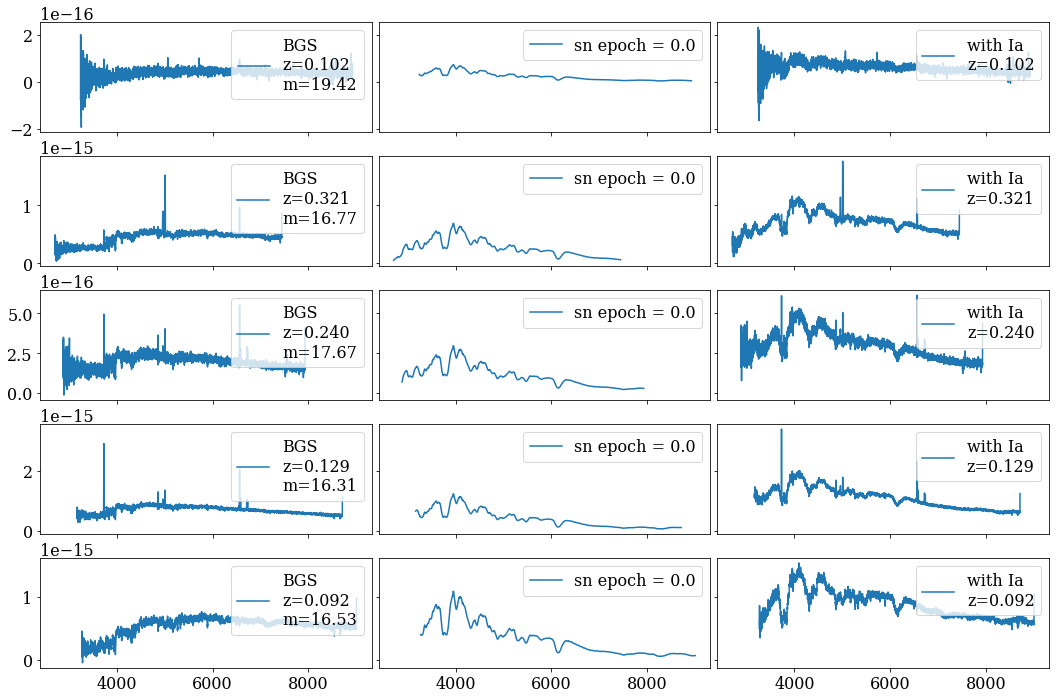

In [11]:
nplots = 5

fig, axes = plt.subplots(nplots,3, figsize=(15, nplots*2), 
                         sharex=True, sharey='row')

for i, sn_host in enumerate(sn_host_table[:nplots]):
    
    spec_id = sn_host['ID']
    galaxy = galaxy_table[galaxy_table['ID'] == spec_id][0]
    
    gal_label="%s\nz=%.3f\nm=%.2f" % (galaxy['OBJTYPE'], galaxy['REDSHIFT'], galaxy['MAG'])
    axes[i,0].plot(galaxy['WAVE'], galaxy['FLUX'], label=gal_label)
    axes[i,0].legend(loc='upper right')
    
    sn_label = "with %s\nz=%.3f" % (sn_host['HAS_SN'], sn_host['REDSHIFT'])
    axes[i,2].plot(sn_host['WAVE'], sn_host['FLUX'], label=sn_label)
    axes[i,2].legend(loc='upper right')
    
    sn_label="sn epoch = %.1f" % 0
    axes[i,1].plot(SN_fluxes[spec_id][0][0], 
                   SN_fluxes[spec_id][1][0], label=sn_label)
    axes[i,1].legend(loc='upper right')

fig.tight_layout(h_pad=0, w_pad=0)

# plt.savefig('../plots/galaxies_with_sn.png', format='png', 
#             dpi=300, bbox_inches='tight')

## Measure amplitudes of features

Table of feature boundaries in type Ia supernova spectra

from https://arxiv.org/pdf/1011.6227.pdf

| Feature | Dominating line | Lower region (centre A) | Upper region (centre A) | Rest wavelength (A) |
|---------||----------------|-------------------------||---------------|
|f1 | Ca II H&K           | 3450 - 3800 | 3800 - 4100 | 3945.12 |
|f2 | Si II $\lambda$4000 | 3800 - 3950 | 4000 - 4200 | 4129.73 |
|f3 | Mg II $\lambda$4300 | 3850 - 4250 | 4300 - 4700 | 4481.20 |
|f4 | Fe II $\lambda$4800 | 4300 - 4700 | 4950 - 5600 | 5083.42 |
|f5 | S II W              | 5050 - 5300 | 5500 - 5750 | 5536.24 |
|f6 | Si II $\lambda$5800 | 5400 - 5700 | 5800 - 6000 | 6007.70 |
|f7 | Si II $\lambda$6150 | 5800 - 6100 | 6200 - 6600 | 6355.21 |

In [42]:
features = {
#   id     center    lower region    upper region
    "f1": [3800, [3450, 3800], [3800, 4000]],
    "f2": [4000, [3900, 3950], [4050, 4200]],
    "f3": [4300, [4000, 4250], [4300, 4700]],
    "f4": [4800, [4300, 4700], [4950, 5600]],
    "f5": [5475, [5050, 5300], [5500, 5750]],
    "f6": [5800, [5400, 5700], [5800, 6000]],
    "f7": [6150, [5900, 6100], [6200, 6500]],
}
# features = {
# #   id     center    min    max
#     "f1": [3800, 3700, 3900],
#     "f2": [4000, 3950, 4100],
#     "f3": [4300, 4200, 4400],
#     "f4": [4850, 4700, 5000],
#     "f5": [5475, 5400, 5550],
#     "f6": [5800, 5750, 5850],
#     "f7": [6150, 6000, 6300],
# }
featurenames = {
#   id     center    min    max
    "f1": "Ca II H&K",
    "f2": "Si II $\lambda$4000",
    "f3": "Mg II $\lambda$4300",
    "f4": "Fe II $\lambda$4800",
    "f5": "S II W",
    "f6": "Si II $\lambda$5800",
    "f7": "Si II $\lambda$6150",
}

In [13]:
def lowPassFilter(signal, fc, b):
    N = int(np.ceil((4 / b)))
    if not N % 2:
        N += 1
    n = np.arange(N)
    sinc_func = np.sinc(2 * fc * (n - (N - 1) / 2.))
    window = 0.42 - 0.5 * np.cos(2 * np.pi * n / (N - 1)) + 0.08 * np.cos(4 * np.pi * n / (N - 1))
    sinc_func = sinc_func * window
    sinc_func = sinc_func / np.sum(sinc_func)
    return N, np.convolve(signal, sinc_func)

def highPassFilter(signal, fc, b):
    N = int(np.ceil((4 / b)))
    if not N % 2:
        N += 1
    n = np.arange(N)
 
    sinc_func = np.sinc(2 * fc * (n - (N - 1) / 2.))
    window = np.blackman(N)
    sinc_func = sinc_func * window
    sinc_func = sinc_func / np.sum(sinc_func)

    # reverse function
    sinc_func = -sinc_func
    sinc_func[(N - 1) // 2] += 1

    return N, np.convolve(signal, sinc_func)

In [14]:
def get_feature_box(feature, spectrum):
    
    flux = spectrum['RESAMPLED_FLUX'] 
    lowercut = ((global_wavelength_grid > feature[1][0]) &
                    (global_wavelength_grid < feature[1][1]))
    uppercut = ((global_wavelength_grid > feature[2][0]) &
                    (global_wavelength_grid < feature[2][1]))
    
    lowerregion = global_wavelength_grid[lowercut]
    upperregion = global_wavelength_grid[uppercut]
    
#     lowerregion_flux = flux[lowercut]
#     upperregion_flux = flux[uppercut]
    
    # Using low pass filters
    fc, b = 0.01, 0.01
    N, lpf = lowPassFilter(flux, fc=fc, b=b)
    dN = (N-1) // 2
    lpf = lpf[dN:-dN]
    
    lowerregion_flux = lpf[lowercut]
    upperregion_flux = lpf[uppercut]

    lowerbound = lowerregion[np.argmax(lowerregion_flux)]
    upperbound = upperregion[np.argmax(upperregion_flux)]
        
    featurecut = ((global_wavelength_grid > lowerbound) &
                    (global_wavelength_grid < upperbound))
    
    feature_wave = global_wavelength_grid[featurecut]
    feature_flux = lpf[featurecut] # flux[featurecut]
    
    # Define the pseudo-continuum
    fluxdiff = (feature_flux[-1] - feature_flux[0])
    waverange = (upperbound - lowerbound)
    slope = fluxdiff / waverange
    
    pseudo_continuum = feature_flux[0]+slope*(feature_wave-lowerbound)

    return [feature_wave, feature_flux, pseudo_continuum], lpf



In [15]:
def get_pEW(feature, spectrum):
    
    # Get the bounding box to calculate the pEW in
    feature_box, lpf = get_feature_box(feature, spectrum)
    feature_wave, feature_flux, pseudo_continuum = feature_box
    
    pEW = np.sum(1. - feature_flux/pseudo_continuum)    
    
    return pEW

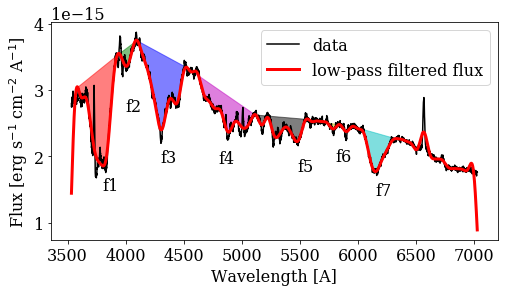

In [71]:
spectrum = sn_host_table[55]
# spectrum = galaxy_table[55]

fig, ax = plt.subplots(1,1, figsize=(8,4))
flux = spectrum['RESAMPLED_FLUX']
continuum = spectrum['CONTINUUM_FLUX']
residual  = flux - continuum

ax.plot(global_wavelength_grid, flux, color='k', label='data')
# ax.plot(global_wavelength_grid, continuum, color='r')
# ax.plot(global_wavelength_grid, residual, color='b')
# ax.axhline(0, ls='--', color='k')

colors = 'rgbmkyc'

for i, fn in enumerate(features):
    feature = features[fn]
    
#     ax.axvline(feature[0], ls='-', lw=2, 
#                color=colors[i], label=featurenames[fn])

    feature_box, lpf = get_feature_box(feature, spectrum)
    feature_wave, feature_flux, pseudo_continuum = feature_box
    feature_cut = ((global_wavelength_grid > feature_wave[0]) &
                    (global_wavelength_grid < feature_wave[-1]))
    
    middle = np.argmin(lpf[feature_cut])
    ax.text(feature[0], 0.8*feature_flux[middle-1], fn)
    
#     ax.axvspan(feature_wave[0], feature_wave[-1],
#                 alpha=0.25, color=colors[i])
    ax.fill_between(feature_wave, pseudo_continuum, feature_flux,
                   color=colors[i], alpha=0.5)
ax.plot(global_wavelength_grid, lpf, color='r', 
        lw=3, label='low-pass filtered flux')

ax.set(xlabel='Wavelength [A]', 
       ylabel=r'Flux [erg s$^{-1}$ cm$^{-2}$ A$^{-1}$]')
# ax.legend(loc='center', bbox_to_anchor=[1.2,.5])
ax.legend(loc='upper right')

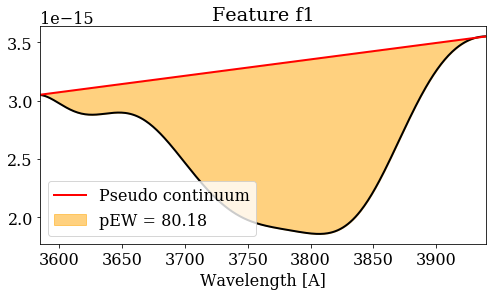

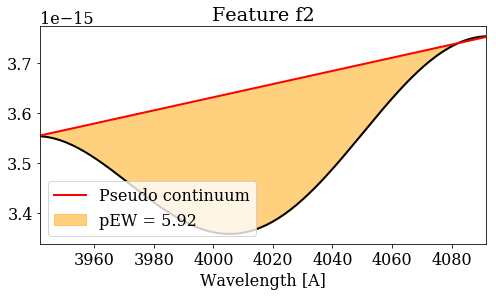

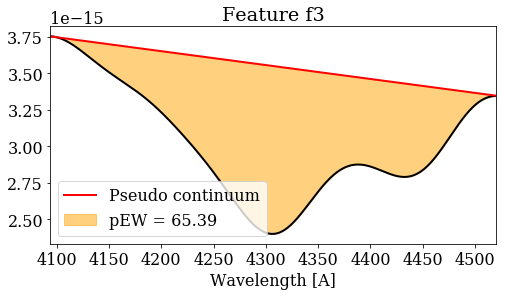

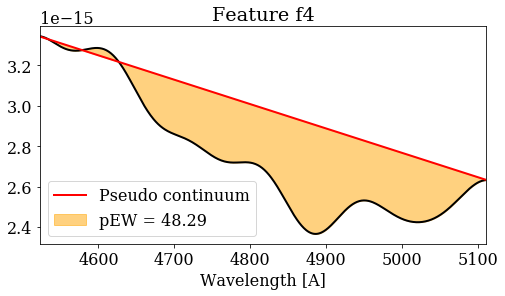

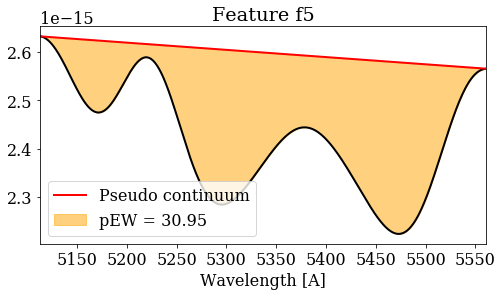

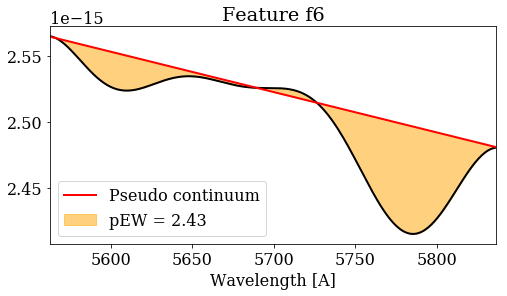

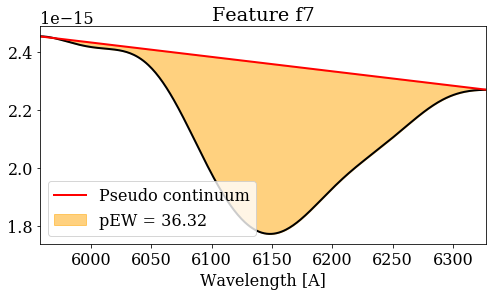

In [72]:
for fn in sorted(features.keys()): # ['f7']:
    feature = features[fn]
    
    feature_box, lpf = get_feature_box(feature, spectrum)
    feature_wave, feature_flux, pseudo_continuum = feature_box
    feature_cut = ((global_wavelength_grid > feature_wave[0]) &
                    (global_wavelength_grid < feature_wave[-1]))
    
    pEW = get_pEW(feature, spectrum)
    
    fig, ax = plt.subplots(1,1, figsize=(8,4))
    ax.plot(feature_wave, feature_flux, color='k', lw=2)
    ax.plot(feature_wave, pseudo_continuum, label='Pseudo continuum',
           color='r', lw=2)
    ax.fill_between(feature_wave, pseudo_continuum, y2=feature_flux,
                   color='orange', alpha=0.5, label='pEW = %.2f' % pEW)

    ax.set(xlabel='Wavelength [A]', #ylabel='Residual',
          xlim=[feature_wave[0], feature_wave[-1]],
          title='Feature %s' % fn)
    ax.legend(loc='lower left')

In [18]:
pEW_features = []
for spectrum in spec_table:
    pEWs = []
    gaussian_amplitudes = []
    for fn in sorted(features.keys()):
        feature = features[fn]
        pEW = get_pEW(feature, spectrum)
        pEWs.append(pEW)
        
    pEW_features.append(pEWs)
    
spec_table['pEW_FEATURES'] = pEW_features


## Run random forest classifier on featureset

In [19]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier

In [20]:
# Load feature values into one overall table
# each column = one feature
table  = []
names  = []
dtypes = []

num_features = len(features)

for spec in spec_table:
    tablerow = np.append(spec['pEW_FEATURES'], spec['HAS_SN'])
    table.append(tablerow)

for i in range(1,num_features+1):
    names.append("f%d" % i)
    dtypes.append(np.float32)
    
names.append('HAS_SN')
dtypes.append('S')

data = Table(rows=table, names=names, dtype=dtypes)

In [21]:
df = data.to_pandas()

In [22]:
df[:5]

,f1,f2,f3,f4,f5,f6,f7,HAS_SN
0,72.373886,3.877352,56.691460,42.322094,26.070547,2.076031,31.269211,Ia
1,37.032288,6.815499,45.605747,29.802017,2.849313,4.560116,9.859233,0.0
2,67.792908,3.675832,47.507694,41.361210,27.531223,2.252198,32.203640,Ia
3,20.463472,6.693882,42.065701,12.169666,10.032348,4.302741,1.713082,0.0
4,13.495647,6.477632,47.325497,2.340144,1.143346,5.473247,2.031721,0.0


In [23]:
df['is_train'] = np.random.uniform(0, 1, len(df)) <= 0.75

In [24]:
# We now split the dataframes into a test and training dataset
train, test = df[df['is_train']==True], df[df['is_train']==False]
print 'Number of observations in the training data:', len(train)
print 'Number of observations in the test data:',len(test)

Number of observations in the training data: 28259
Number of observations in the test data: 9541


In [25]:
train_count = Counter(train['HAS_SN'])
test_count  = Counter(test['HAS_SN'])

trainstr = ""
for k in train_count.keys():
    trainstr += "%s %d," % (k, train_count[k])
print "Training set: %d: (%s)" % (len(train), trainstr)
    
teststr = ""
for k in test_count.keys():
    teststr += "%s %d," % (k, test_count[k])
print "Training set: %d: (%s)" % (len(test), teststr)

Training set: 28259: (Ia 14103,0.0 14156,)
Training set: 9541: (Ia 4797,0.0 4744,)


In [43]:
rf_features = df.columns[:-2]
rf_features

Index([u'f1', u'f2', u'f3', u'f4', u'f5', u'f6', u'f7'], dtype='object')

In [44]:
# train['species'] has the "true" species names
# in order to compare later it needs to be coded into integers (0, 1, 2)

y, objtypes = pd.factorize(train['HAS_SN'])

# Now we train the random forest
clf = RandomForestClassifier(n_jobs=1, 
                             random_state=0,
                             verbose=0)

clf.fit(train[rf_features], y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

In [45]:
# Apply the classifier to the test data
clf.predict(test[rf_features])

array([1, 0, 1, ..., 0, 0, 1])

In [46]:
# View prediction probabilities
clf.predict_proba(test[rf_features])[0:10]

array([[ 0.,  1.],
       [ 1.,  0.],
       [ 0.,  1.],
       [ 1.,  0.],
       [ 0.,  1.],
       [ 1.,  0.],
       [ 0.,  1.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 0.,  1.]])

In [47]:
# Convert back to english
preds = [objtypes[i] for i in clf.predict(test[rf_features])]

In [48]:
from pandas_ml import ConfusionMatrix

cm = ConfusionMatrix(test['HAS_SN'].tolist(), preds)
cm.print_stats()

population: 9541
P: 4797
N: 4744
PositiveTest: 4799
NegativeTest: 4742
TP: 4796
TN: 4741
FP: 3
FN: 1
TPR: 0.999791536377
TNR: 0.99936762226
PPV: 0.999374869765
NPV: 0.999789118515
FPR: 0.000632377740304
FDR: 0.000625130235466
FNR: 0.000208463623098
ACC: 0.999580756734
F1_score: 0.99958315965
MCC: 0.999161573455
informedness: 0.999159158637
markedness: 0.99916398828
prevalence: 0.502777486637
LRP: 1581.00368286
LRN: 0.00020859553427
DOR: 7579278.66667
FOR: 0.000210881484606


In [49]:
# Display how well the classifier did via a confusion matrix

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test['HAS_SN'], preds, labels=objtypes)
print objtypes
print cm

Index([u'0.0', u'Ia'], dtype='object')
[[4741    3]
 [   1 4796]]


In [50]:
correct = 0
incorrect = 0
for true, pred in zip(test['HAS_SN'], preds):
    if true == pred:
        correct += 1
#         print true, pred
    else:
        incorrect+= 1
#         print true, pred
        
print correct, incorrect

9537 4


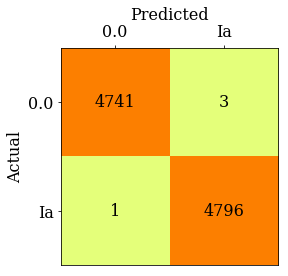

In [51]:
norm_cm = []
for i in cm:
    a = 0
    tmp_arr = []
    a = sum(i, 0)
    for j in i:
        tmp_arr.append(float(j)/float(a))
    norm_cm.append(tmp_arr)

fig = plt.figure()
plt.clf()
ax = fig.add_subplot(111)
ax.set_aspect(1)
res = ax.imshow(np.array(norm_cm), cmap='Wistia',
                interpolation='nearest')

width, height = cm.shape

for x in xrange(width):
    for y in xrange(height):
        ax.annotate(str(cm[x][y]), xy=(y, x), 
                    color='k',
                    horizontalalignment='center',
                    verticalalignment='center')

# cb = fig.colorbar(res)
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
plt.xticks(range(width), objtypes[:width])
plt.yticks(range(height), objtypes[:height])
plt.xlabel('Predicted')
plt.ylabel('Actual')
# plt.savefig('../plots/confusion_matrix.png', format='png', 
#             dpi=300, bbox_inches='tight')

### Relative importance of features

In [52]:
list(zip(train[rf_features], clf.feature_importances_))

[('f1', 0.1244692533455376),
 ('f2', 0.018761510471049892),
 ('f3', 0.080081645801838325),
 ('f4', 0.0085158401848579729),
 ('f5', 0.21486702133272098),
 ('f6', 0.0011776246532897788),
 ('f7', 0.55212710421070532)]

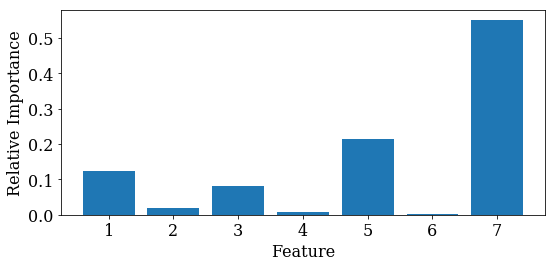

In [53]:
fig, ax = plt.subplots(1,1, figsize=(8,4))

# Label line
ax.bar(range(1,len(rf_features)+1), clf.feature_importances_)
ax.set(xlabel='Feature',
       ylabel='Relative Importance')
fig.tight_layout()

### Examine misclassified spectra

In [54]:
misclassified = test[test['HAS_SN'] != preds]

In [55]:
clf.predict_proba(misclassified[rf_features])[:10]

array([[ 0.4,  0.6],
       [ 0.5,  0.5],
       [ 0.4,  0.6],
       [ 0.2,  0.8]])

In [56]:
test_specs          = spec_table[np.asarray(df['is_train']==False)]
misclassified_specs = test_specs[np.asarray(test['HAS_SN'] != preds)]

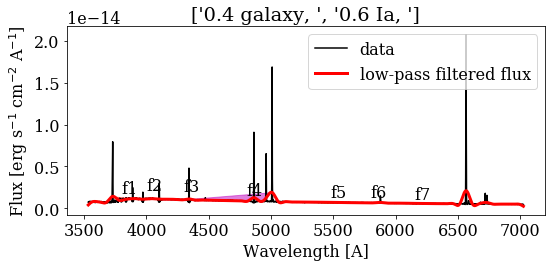

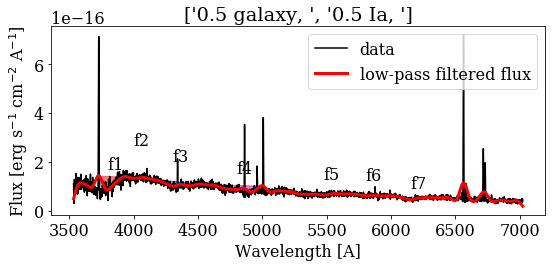

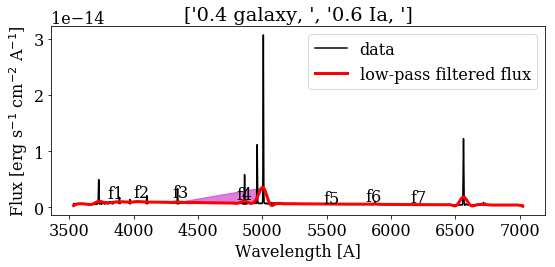

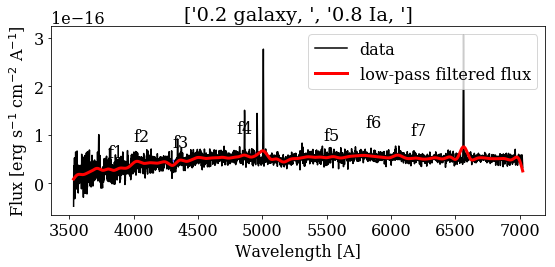

In [69]:
pred_probs = clf.predict_proba(misclassified[rf_features])

for i, spectrum in enumerate(misclassified_specs):
    
    fig, ax = plt.subplots(1,1, figsize=(8,4))
    flux = spectrum['RESAMPLED_FLUX']
    
    predicted_prob = clf.predict_proba(misclassified[rf_features])[i]

    ax.plot(global_wavelength_grid, flux, color='k', label='data')
    colors = 'rgbmkyc'
    for i, fn in enumerate(features):
        feature = features[fn]

    #     ax.axvline(feature[0], ls='-', lw=2, 
    #                color=colors[i], label=featurenames[fn])

        feature_box, lpf = get_feature_box(feature, spectrum)
        feature_wave, feature_flux, pseudo_continuum = feature_box
        feature_cut = ((global_wavelength_grid > feature_wave[0]) &
                        (global_wavelength_grid < feature_wave[-1]))

        middle = np.argmin(lpf[feature_cut])
        ax.text(feature[0], 2*feature_flux[middle-1], fn)

    #     ax.axvspan(feature_wave[0], feature_wave[-1],
    #                 alpha=0.25, color=colors[i])
        ax.fill_between(feature_wave, pseudo_continuum, feature_flux,
                       color=colors[i], alpha=0.5)
    ax.plot(global_wavelength_grid, lpf, color='r', 
            lw=3, label='low-pass filtered flux')

    classes = ['galaxy', 'Ia']
    titlestring = ["%.1f %s, " % (p, o) for p, o in zip(predicted_prob, classes)]
    ax.set(title=titlestring,
           xlabel='Wavelength [A]', 
           ylabel=r'Flux [erg s$^{-1}$ cm$^{-2}$ A$^{-1}$]')
    # ax.legend(loc='center', bbox_to_anchor=[1.2,.5])
    ax.legend(loc='upper right')
    fig.tight_layout()